In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
from datetime import date
import glob
import os
import io
from pandas.plotting import table 
from PIL import Image


In [192]:
# path= _
# carteira= pd.read_csv(path + 'csvWallet.csv', sep=';', encoding = "ISO-8859-1", decimal=',')
# opmes= pd.read_csv(path + 'csvmonth.csv', sep=';', encoding = "ISO-8859-1", decimal=',')

directory='Ano2020/Novembro/'

# carteira= pd.read_csv('csvWallet.csv', sep=';', encoding = "ISO-8859-1", decimal='.')
carteira= pd.read_csv('Ano2020/Novembro/carteirames_10.csv', sep=',', encoding = "ISO-8859-1", decimal='.')

# opmes= pd.read_csv('csvmonth.csv', sep=';', encoding = "ISO-8859-1", decimal='.')
opmes= pd.read_csv('Ano2020/Novembro/resumomensal.csv', sep=',', encoding = "ISO-8859-1")


In [193]:
# Verifica se todos as transações são do mesmo mês
mesesdict= {1:'Jan',2:'Fev',3:'Mar', 4:'Abr', 5:'Mai', 6:'Jun', 7:'Jul', 8:'Ago',9:'Set', 10:'Out', 11:'Nov', 12:'Dez'}
from dateutil.parser import parse
month=[]
last= parse(opmes.Pregao.loc[opmes.first_valid_index()], dayfirst=True).month
for date in opmes.Pregao.unique():
    moddate= parse(date.replace('C',''), dayfirst=True)
    assert moddate.month == last , f'{moddate.month} mês {last}'
    last= moddate.month
    month.append(moddate)


In [194]:
opmes.head(2)

,Pregao,Operacao,Ticker,Quantidade,Preco/Acao,ValorOp,Liquido,Despesas,IRRF
0,09/11/2020,C,TASA4,2000,8.3,16600.0,16613.31,13.31,0.0
1,10/11/2020,C,MRFG3,2000,14.2,28400.0,28419.31,19.31,0.0


In [195]:
carteira.head(2)

,Ticker,Quantidade,ValorInvestimento
0,PETR4,1300.0,23442.706535
1,BRSR6,400.0,8182.550000


In [196]:
#add/delete row for tests

# opmes.dropna()
# opmes= opmes.drop(7)

# opmes.loc[opmes.last_valid_index() + 1]= ['30/12/2020', 'V', 'TASA4', 5000, 16, 80000, 80050, 50]

# opmes= opmes.replace('BRADESCOPNEJN1','BBDC4')
# opmes= opmes.replace('WEGONEDNM','WEGE3')
# opmes= opmes.replace('ITAUUNIBANCOPNEDJN1','ITUB4')

In [197]:
# #mudara depois
carteira['Operacao'] = 'C'
carteira['Pregao'] = '01/01/0001'
carteira= carteira[['Pregao', 'Operacao','Ticker', 'Quantidade', 'ValorInvestimento']]

opmes= opmes.drop(['Preco/Acao'], axis= 1)

# #ajustes
# # carteira["Ticker"]= carteira["Ticker"].replace("Ticker", "Ticker2") 
# opmes["Ticker"]= opmes["Ticker"].replace("GOLL3", "GOLL4") 
# opmes["Ticker"]= opmes["Ticker"].replace("AZUL3", "AZUL4") 
# opmes['Despesas']=0

In [198]:
# calcula valor total das despesas do pregão
despesaslist= []
# for index, row in opmes.iterrows():
for pregao in opmes.Pregao.unique():
    opmes1= opmes[opmes.Pregao == pregao].copy()
    bruto= 0
    
    for index, row in opmes1.iterrows():
        ticker = opmes1.Ticker[index]
    #     print(index, ' ', ticker)
    #     print(row['Ticker'], ticker)
        if opmes1.Operacao[index] == 'C':
            bruto= bruto + opmes1.ValorOp[index]
        elif opmes1.Operacao[index] == 'V':
            bruto= bruto - opmes1.ValorOp[index]
        else:
            break
       
    liquido1= np.round(abs(row['Liquido'] - abs(bruto)),2) 
#     print(pregao, opmes1['Despesas'].values, f'Valor calculado: {liquido1}')
    opmes1.loc[:,'Despesas']= liquido1
    despesaslist.append(opmes1)


#recria o dataframe com as despesas calculadas
assert  np.all(opmes['Despesas'].values == pd.concat(despesaslist)['Despesas'].values), 'Values do not match'
opmes= pd.concat(despesaslist)

In [199]:
opmes= opmes.sort_values('Pregao')

In [200]:

opmes.head(25)


,Pregao,Operacao,Ticker,Quantidade,ValorOp,Liquido,Despesas,IRRF
0,09/11/2020,C,TASA4,2000,16600.0,16613.31,13.31,0.00
1,10/11/2020,C,MRFG3,2000,28400.0,28419.31,19.31,0.00
2,17/11/2020,V,TASA4,2000,19600.0,19585.16,14.84,0.00
3,20/11/2020,C,MGLU3,500,12050.0,12061.01,11.01,0.00
4,23/11/2020,V,BRSR6,400,5140.0,15324.02,24.02,1.24
5,23/11/2020,C,TASA4,2000,20440.0,15324.02,24.02,1.24
6,26/11/2020,V,MRFG3,2000,30100.0,30078.34,21.66,1.50
7,27/11/2020,C,TASA4,4000,50000.0,20651.55,51.55,1.47
8,27/11/2020,V,ITUB4,1000,29400.0,20651.55,51.55,1.47


In [201]:
# carteira= carteira.replace(1000, 1050)

carteira.head(25)

,Pregao,Operacao,Ticker,Quantidade,ValorInvestimento
0,01/01/0001,C,PETR4,1300.0,23442.706535
1,01/01/0001,C,BRSR6,400.0,8182.550000
2,01/01/0001,C,TRPL4,700.0,14185.510000
3,01/01/0001,C,BBDC4,550.0,13909.746190
4,01/01/0001,C,ITUB4,1300.0,34435.840000


# Ajustes

In [202]:
# calcula valor individual das despesas
despesaslist= []

for pregao in opmes[opmes.Pregao.duplicated()].Pregao:
    opmes1= opmes[opmes.Pregao == pregao].copy()
    bruto= 0
    
    for index, row in opmes1.iterrows():
        ticker = row['Ticker']
    
### Isso aqui funciona
    #calcula valor correto das despesas
        despesa= np.round_(row['Despesas']*(row['ValorOp'] / opmes1['ValorOp'].sum()),2)
#         print(despesa)
        #calcula valor liquido correto
        if row['Operacao'] == 'C':
          liquido= row['ValorOp'] + despesa

        elif row['Operacao'] == 'V':
          liquido= row['ValorOp'] - despesa

        else:
          break

        despesaslist.append([index, despesa, liquido])

In [203]:
# print(despesaslist)
for index, despesa, liquido in despesaslist:
  # print(index, despesa)
  opmes.loc[index,'Despesas'] = despesa
  opmes.loc[index,'Liquido'] = liquido

In [204]:
#plotly
def dataframe_to_img(df, title, path='.'):
    import plotly.figure_factory as ff
    n_rows= len(df.index)
    n_cols= len(df.columns)
    fig =  ff.create_table(df)
    #title
    fig.layout.margin.update({'t':50, 'b':100})
    fig.layout.update({'title': f'{title}'})
    #------
    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i].font.size = 22
    fig.update_layout(
        autosize=True,
        width=1200,
        height=n_rows*50 + 100,
    )
    fig.write_image(os.path.join(path,title+'.png'), format= 'png', scale=1)
    fig.show()
    return

## matplotlib + pandas
# def dataframe_to_img(df, title, path='.'):
#     plt.figure(figsize=(12, 10))
#     ax = plt.subplot(20,1,1, frame_on=False) # no visible frame
#     ax.set_aspect('auto', anchor= 'N')
#     ax.xaxis.set_visible(False)  # hide the x axis
#     ax.yaxis.set_visible(False)  # hide the y axis
# #     the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center')
# #     plt.rcParams.update({'font.size': 14})
#     dftable= table(ax, df, fontsize= 18)  # where df is your data frame
#     plt.title(title)
#     plt.savefig(os.path.join(path,title+'.png'), dpi=300)
#     return 

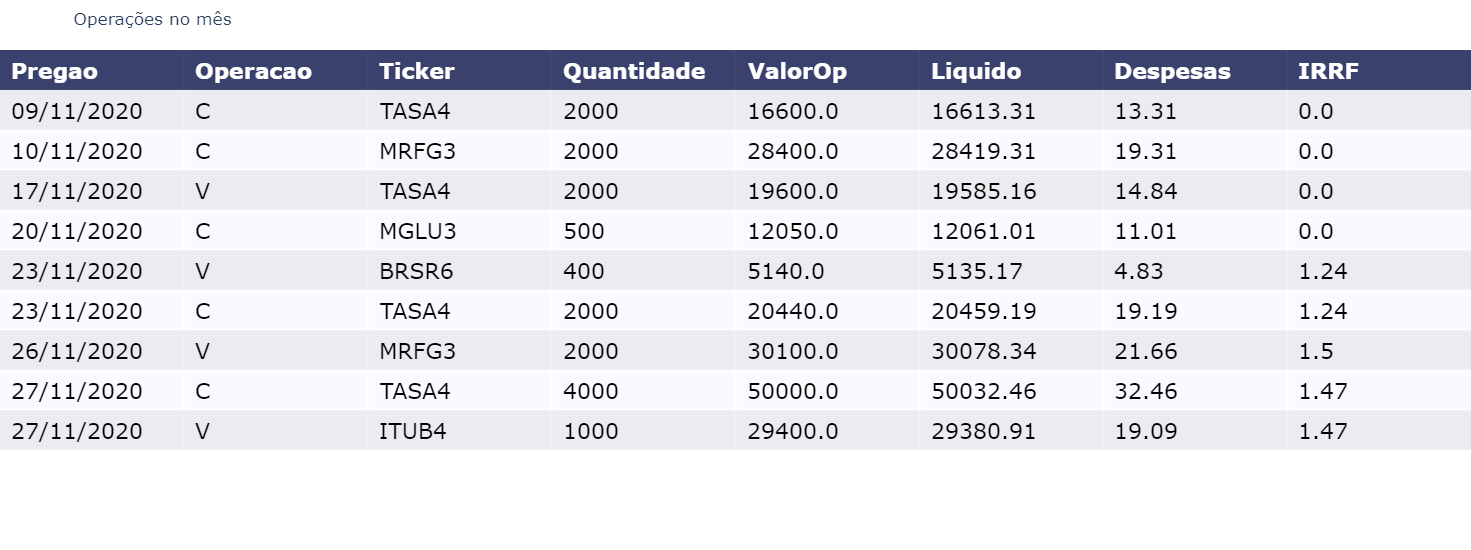

In [205]:
dataframe_to_img(opmes, "Operações no mês", path= './relatorios')

# Calculos

In [206]:
operacoes= opmes[['Operacao', 'Ticker', 'Quantidade', 'Liquido']]
# operacoes.head()

In [207]:
# del(carteira) #deleta variável da carteira
######################
try:
    newcarteiralist= carteira.values.tolist() #quando vazio não declarar a carteira = erro
except:
    newcarteiralist= [] #para carteira vazia 
#####################    

for index, row in opmes.iterrows():
    newcarteiralist.append([opmes.Pregao[index], opmes.Operacao[index], opmes.Ticker[index], opmes.Quantidade[index], opmes.Liquido[index]])

In [208]:
print(len(newcarteiralist))
newcarteira= pd.DataFrame(newcarteiralist, columns= ['Pregao', 'Operacao','Ticker', 'Quantidade', 'ValorInvestimento'])
newcarteira= newcarteira.sort_values(by='Pregao')
# newcarteiradf= newcarteiradf.reset_index(drop= True)
newcarteira.head(25)

14


,Pregao,Operacao,Ticker,Quantidade,ValorInvestimento
0,01/01/0001,C,PETR4,1300.0,23442.706535
1,01/01/0001,C,BRSR6,400.0,8182.550000
2,01/01/0001,C,TRPL4,700.0,14185.510000
3,01/01/0001,C,BBDC4,550.0,13909.746190
4,01/01/0001,C,ITUB4,1300.0,34435.840000
5,09/11/2020,C,TASA4,2000.0,16613.310000
6,10/11/2020,C,MRFG3,2000.0,28419.310000
7,17/11/2020,V,TASA4,2000.0,19585.160000
8,20/11/2020,C,MGLU3,500.0,12061.010000
9,23/11/2020,V,BRSR6,400.0,5135.170000


In [209]:
ops= ['C', 'V', 'w']
op_compra= []
op_venda= []

newwallet= []
ir_list= []

for ticker in newcarteira.Ticker.unique():
    venda, compra= [np.float32(0),np.float32(0)], [np.float32(0),np.float32(0)]
    temp= newcarteira[newcarteira.Ticker== ticker]
    # print(temp)

    for i, row in temp.iterrows():
        if row['Operacao'] == 'C':
            compra= [(compra[0] + row["Quantidade"]), (compra[1] + row["ValorInvestimento"])] # quantidade, liquido
            pmcompra= compra[1]/compra[0]
            # print(operacao)

        if row['Operacao'] == 'V':
            venda= [row["Quantidade"], np.round_(row["ValorInvestimento"],2)]
            pmvenda= venda[1]/venda[0]
            lucprej= venda[0]*(pmvenda - pmcompra)

            newquant= compra[0] - venda[0]
            compra= [newquant, (newquant * pmcompra)]

            op_venda.append([ticker, venda[0], venda[1], np.round_(pmcompra*venda[0],2), np.round_(lucprej,2)])

    if compra[0] > 0:      
        op_compra.append([ticker, compra[0], compra[1]])
newwallet= op_compra
ir_list= op_venda

#################################

# #Calcula lucro no periodo (nao sequencial)

# for ticker in newcarteira.Ticker.unique():
#     venda, compra= [np.float32(0),np.float32(0)], [np.float32(0),np.float32(0)]
#     temp= newcarteira[newcarteira.Ticker== ticker]
#     # print(temp)
#     for operacao in ops:
#         temp2= temp[temp.Operacao == operacao]

#         if not temp2.empty:
#           # print(temp2)
#             if operacao == 'C':
#                 compra= [temp2["Quantidade"].sum(), temp2["ValorInvestimento"].sum()] # quantidade, liquido
#                 op_compra.append([ticker, compra])
#                 pmcompra= compra[1]/compra[0]
#                 # print(operacao)

#             if operacao == 'V':
#                 venda= [temp2["Quantidade"].sum(), np.round_(temp2["ValorInvestimento"].sum(),2)]
#                 op_venda.append([ticker, venda])
#                 pmvenda= venda[1]/venda[0]


#     newquant= compra[0] - venda[0]
#     newliq= np.round_(pmcompra * newquant,2)


#     if venda[0] > 0:
#         lucprej= venda[0]*(pmvenda - pmcompra)

#     if newquant > 0:
#         #     newwallet.append([ticker, newquant, newliq, pmcompra])
#         newwallet.append([ticker, newquant, newliq])
#     if venda[1] > 0:
#         ir_list.append([ticker, venda[0], venda[1], np.round_(pmcompra*venda[0],2), np.round_(lucprej,2)])  

In [210]:
# print(newwallet)
# print(ir_list)

In [211]:
# Calcula IRRF

irrf_list= []
for op in opmes['Pregao'].unique():
    irrf= opmes[opmes.Pregao == op].IRRF.to_list()[0]
    irrf_list.append(irrf)
#     print(opmes[opmes.Pregao == op].IRRF.to_list()[0])
irrf_total= np.round_(np.sum(irrf_list),2)
print(f'{irrf_list}, Total: {irrf_total}')

[0.0, 0.0, 0.0, 0.0, 1.24, 1.5, 1.47], Total: 4.21


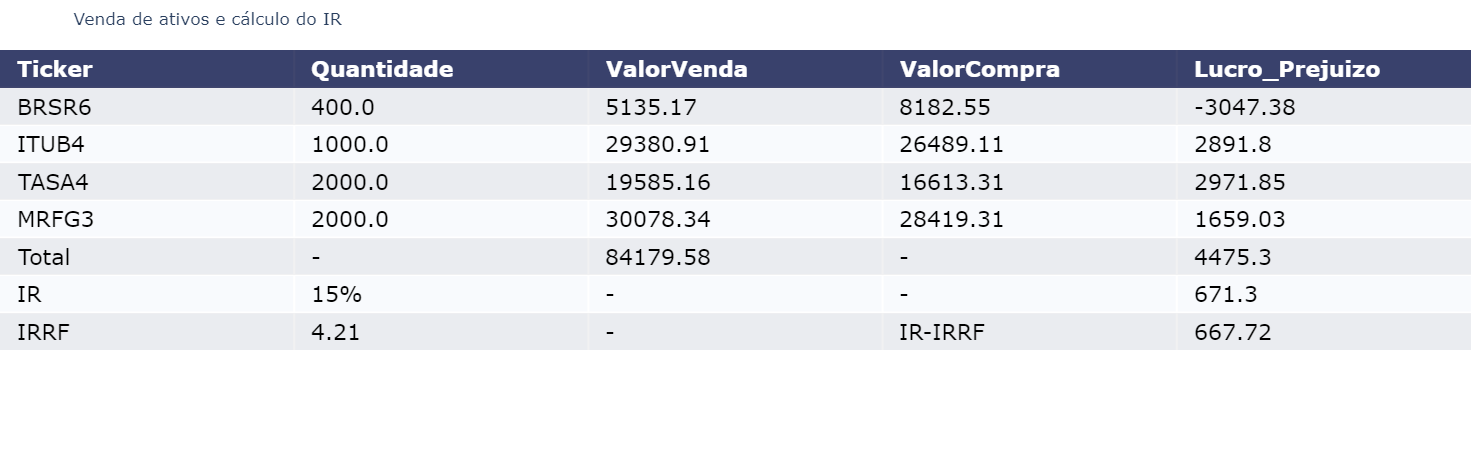

In [212]:
try:
    calculoir= pd.DataFrame(ir_list, columns= ['Ticker', 'Quantidade', 'ValorVenda','ValorCompra', 'Lucro_Prejuizo'])

    lucroprej= np.round_(calculoir.Lucro_Prejuizo.sum(),2)
    vendames= np.round_(calculoir.ValorVenda.sum(),decimals=2)
    calculoir.loc[calculoir.last_valid_index() + 1]= ['Total', '-', vendames,'-', lucroprej]
    if vendames < 20000:
        calculoir.loc[calculoir.last_valid_index() + 1]= ['IR', '-','-', '<R$20000',  'isento']
    else: 
        calculoir.loc[calculoir.last_valid_index() + 1]= ['IR', '15%', '-','-', np.round_(lucroprej*0.15,2)]
        calculoir.loc[calculoir.last_valid_index() + 1]= ['IRRF', irrf_total, '-', 'IR-IRRF',np.round_(lucroprej*0.15-0.85*irrf_total,2)]
        
    dataframe_to_img(calculoir, "Venda de ativos e cálculo do IR", path= './relatorios')
except:
    print('Nenhuma venda realizada')

In [213]:
opmes

,Pregao,Operacao,Ticker,Quantidade,ValorOp,Liquido,Despesas,IRRF
0,09/11/2020,C,TASA4,2000,16600.0,16613.31,13.31,0.00
1,10/11/2020,C,MRFG3,2000,28400.0,28419.31,19.31,0.00
2,17/11/2020,V,TASA4,2000,19600.0,19585.16,14.84,0.00
3,20/11/2020,C,MGLU3,500,12050.0,12061.01,11.01,0.00
4,23/11/2020,V,BRSR6,400,5140.0,5135.17,4.83,1.24
5,23/11/2020,C,TASA4,2000,20440.0,20459.19,19.19,1.24
6,26/11/2020,V,MRFG3,2000,30100.0,30078.34,21.66,1.50
7,27/11/2020,C,TASA4,4000,50000.0,50032.46,32.46,1.47
8,27/11/2020,V,ITUB4,1000,29400.0,29380.91,19.09,1.47


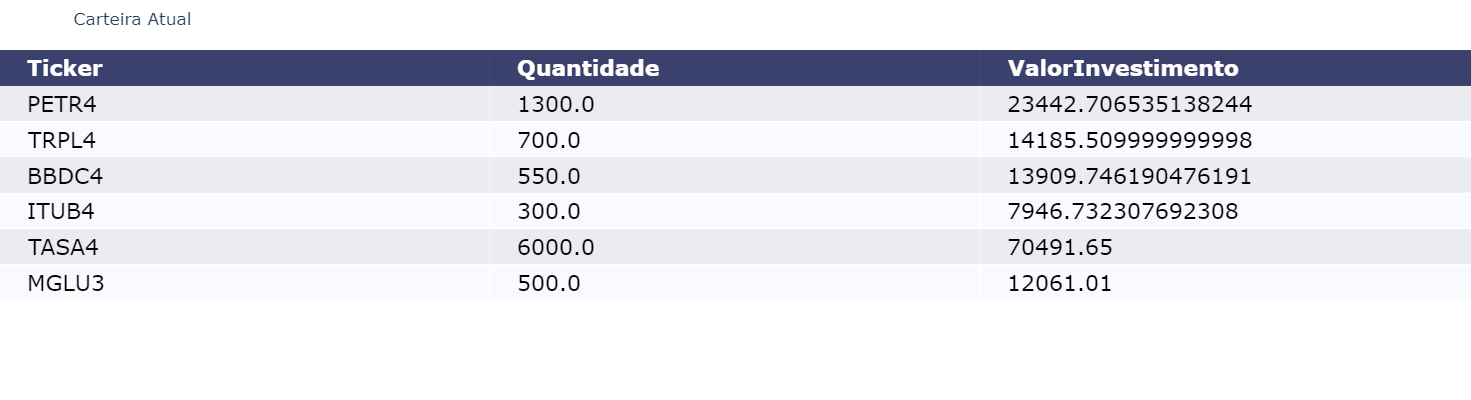

In [214]:
# carteira2= pd.DataFrame(newwallet, columns= ['Ticker', 'Quantidade', 'ValorInvestimento', 'PrecoMedio'])
carteira2= pd.DataFrame(newwallet, columns= ['Ticker', 'Quantidade', 'ValorInvestimento'])
# carteira.head()

dataframe_to_img(carteira2, "Carteira Atual", path= './relatorios')

In [215]:
# print(month[1].month, mesesdict[month[1].month])

file_name = ( f'irmes_{month[0].month}.csv')
calculoir.to_csv(os.path.join('.','relatorios',file_name), index=False)

In [216]:
file2_name = ( f'carteirames_{month[1].month}.csv')
carteira2.to_csv(os.path.join('.','relatorios',file2_name), index=False)

In [217]:
def convert_img(image_path):
    img= Image.open(image_path)
    conv_img= Image.new('RGB', img.size, (255, 255, 255))
    conv_img.paste(img, mask=img.split()[3])
    return conv_img

In [218]:
# obj= os.listdir('./relatorios')
obj= glob.glob('./relatorios/*.png')

img_list= []
for item in obj:
#     if '.png' in item:
        print(item)
        img_list.append(convert_img(item))
        
pdf1_filename = "Relatorio.pdf"
img_list[0].save(os.path.join('.','relatorios',pdf1_filename), "PDF" ,resolution=100.0, save_all=True, append_images=img_list[1:])
        
# im1= convert_img("operacoes.png")
# im2 = convert_img("calculoir.png")
# im3 = convert_img("carteira.png")
# im_list = [im2,im3]

# pdf1_filename = "Relatorio.pdf"
# im1.save(pdf1_filename, "PDF" ,resolution=100.0, save_all=True, append_images=im_list)


./relatorios\Carteira Atual.png
./relatorios\Operações no mês.png
./relatorios\Venda de ativos e cálculo do IR.png


In [219]:
obj

['./relatorios\\Carteira Atual.png',
 './relatorios\\Operações no mês.png',
 './relatorios\\Venda de ativos e cálculo do IR.png']